## Library

In [1]:
! pip install dgl==1.0.1+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html | tail -n 1
! pip install networkx==3.1 | tail -n 1

In [3]:
import random
import os
import copy
from collections import OrderedDict, defaultdict
from itertools import chain, islice, combinations
from time import time
from tqdm import tqdm

import dgl
from dgl.nn.pytorch import GraphConv
from dgl.nn.pytorch import SAGEConv

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from networkx.algorithms.approximation.clique import maximum_independent_set as mis
import networkx as nx

from main import utils
from main import gnn
from main import instance

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# fix seed
SEED=0
utils.fix_seed(SEED)
torch_type=torch.float32

## Finding Penalty-diversified Solutions

### Step 1: Set hyperparameters

In [13]:
# Set Penalties
penalties=[0.04*i for i in range(1, 50)]

# Graph parameters
N, d, p, graph_type = 1000, 20, None, "reg"
nx_graph = nx.random_regular_graph(d=d, n=N, seed=SEED)
dgl_graph = dgl.from_networkx(nx_graph).to(device)
Q_mats = [utils.qubo_dict_to_torch(nx_graph, 
                                   instance.gen_q_dict_mis_sym(nx_graph,penalty=penalty)
                                  ).to(device) for penalty in penalties]

# GNN Architecture
in_feats = int(dgl_graph.number_of_nodes()**(0.8))
hidden_size=int(in_feats)
num_class=len(penalties)
dropout=0.0
model=gnn.GNNSage_dev(in_feats, 
                      hidden_size, 
                      num_class, 
                      dropout, 
                      device, 
                      agg_type='mean'
                     ).to(device)
embedding= nn.Embedding(dgl_graph.number_of_nodes(), 
                        in_feats
                       ).type(torch_type).to(device)

# Learning Parameters
num_epoch=int(1e+5)
lr=1e-4 
weight_decay=1e-2
tol=1e-5 
patience=1000
vari_param=0
init_reg_param=-10 
annealing_rate=1e-3
check_interval=5000

### Set 2: Define loss function

In [6]:
def loss(probs, reg_param, vari_param=0):
    
    # cost function
    sum_cost=0
    for idx in range(probs.size(1)):
        sum_cost+=probs[:, idx].T @ Q_mats[idx] @ probs[:, idx]
    
    # diversity measure
    vari_term = -1*probs.size(1)*probs.std(dim=1).sum()
    
    # Annealed Term
    reg_term = torch.sum((1-(2*probs-1)**2))
    
    return sum_cost+reg_param*reg_term+vari_param*vari_term, sum_cost/probs.size(1), reg_term, vari_term

### Set 3: Run CTRA-PI-GNN solver

In [7]:
model, bit_strings, cost, reg_term, vari_term, runtime = gnn.fit_model_multishot(model,
                                                                                 dgl_graph, 
                                                                                 embedding,
                                                                                 loss,
                                                                                 num_epoch=num_epoch,
                                                                                 lr=lr, 
                                                                                 weight_decay=weight_decay,
                                                                                 tol=tol, 
                                                                                 patience=patience, 
                                                                                 vari_param=0,
                                                                                 device=device,
                                                                                 annealing=True,
                                                                                 init_reg_param=init_reg_param,
                                                                                 annealing_rate=annealing_rate,
                                                                                 check_interval=check_interval
                                                                                )

【TRAIN EPOCH 0】LOSS 27151.906, COST 6148.474, REG 27412.330, VAR -16182.199, PARAM -10.000
【TRAIN EPOCH 5000】LOSS -138172.766, COST 1061.220, REG 38034.508, VAR -4545.029, PARAM -5.000
【TRAIN EPOCH 10000】LOSS -9024.488, COST -184.173, REG 274.687, VAR -14063.186, PARAM -0.000
【TRAIN EPOCH 15000】LOSS -9122.794, COST -186.186, REG 0.066, VAR -14185.266, PARAM 5.000
Early Stopping 18621


### Visualize result

In [8]:
mis_results=[]
for shot in range(bit_strings.size(1)):
    size_mis, _, number_violation = utils.postprocess_gnn_mis(bit_strings[:, shot], nx_graph)
    mis_results.append([size_mis.item(), number_violation])

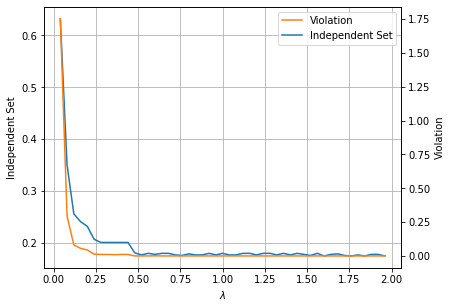

In [9]:
mis_results=np.array(mis_results)

fig, ax_left = plt.subplots(figsize=(6.4, 4.8))
ax_left.plot(np.array(penalties), mis_results[:, 0]/N, label="Independent Set", color="tab:blue")
ax_right = ax_left.twinx()
ax_right.plot(np.array(penalties), mis_results[:, 1]/N, label="Violation", color="tab:orange")
ax_left.grid()
ax_left.set_ylabel("Independent Set")
ax_right.set_ylabel("Violation")
ax_left.set_xlabel(r"$\lambda$")

h1, l1 = ax_right.get_legend_handles_labels()
h2, l2 = ax_left.get_legend_handles_labels()
ax_left.legend(h1+h2, l1+l2)
plt.show()

## Finding Heterogeneous Solutions

### Step1: Setting Hyperparameters

In [10]:
# load problem
Q_data=np.load("data/maxcut/MCPg14.npz")
Adj= -1/2*Q_data['weight']
nx_graph = nx.convert_matrix.from_numpy_array(Adj)
Q_weight = torch.from_numpy(Q_data['weight'].astype(np.float32)).clone().to(device)
Q_bias = torch.from_numpy(Q_data['bias'].astype(np.float32)).clone().to(device)

# GNN Architecture
dgl_graph = dgl.from_networkx(nx_graph).to(device)
in_feats = int(dgl_graph.number_of_nodes()**(0.7))
hidden_size=int(in_feats)
dropout=0.0
num_class=100

model=gnn.GNNSage_dev(in_feats, 
                      hidden_size, 
                      num_class, 
                      dropout, 
                      device, 
                      agg_type='mean'
                     ).to(device)

embedding= nn.Embedding(dgl_graph.number_of_nodes(), 
                        in_feats
                       ).type(torch_type).to(device)

# Learning Parameters
num_epoch=int(1e+5)
lr=1e-4 
weight_decay=1e-2
tol=1e-5 
patience=1000
vari_param=0.4
init_reg_param=-3
annealing_rate=1e-3
check_interval=5000

### Step2: Set Loss Function

In [11]:
def loss(probs, reg_param, vari_param=0):
    
    # cost function
    sum_cost= -0.5*torch.diag(probs.T @ Q_weight @ probs).sum()-(Q_bias @ probs).sum()
    
    # diversity measure
    vari_term = -1*probs.size(1)*probs.std(dim=1).sum()
    
    # Annealed term
    reg_term = torch.sum((1-(2*probs-1)**2))
    
    return sum_cost+reg_param*reg_term+vari_param*vari_term, sum_cost/probs.size(1), reg_term, vari_term

### Step3: Run CTRA-PI-GNN solver

In [ ]:
model, bit_strings, cost, reg_term, vari_term, runtime = gnn.fit_model_multishot(model,
                                                                                 dgl_graph, 
                                                                                 embedding,
                                                                                 loss,
                                                                                 num_epoch=num_epoch,
                                                                                 lr=lr, 
                                                                                 weight_decay=weight_decay,
                                                                                 tol=tol, 
                                                                                 patience=patience, 
                                                                                 vari_param=vari_param,
                                                                                 device=device,
                                                                                 annealing=True,
                                                                                 init_reg_param=init_reg_param,
                                                                                 annealing_rate=annealing_rate,
                                                                                 check_interval=check_interval)

### Visualize results

In [ ]:
maxcut_results=[]
for shot in range(bit_strings.size(1)):
    hamming_dis = torch.sum(bit_strings[:, 0]!=bit_strings[:, shot]).item()
    size_max_cut, [S0, S1], cut_edges, uncut_edges = utils.postprocess_gnn_max_cut(bit_strings[:, shot], nx_graph)
    maxcut_results.append([hamming_dis, size_max_cut])
maxcut_results=np.array(maxcut_results)
    
# PCA
data=bit_strings.detach().cpu().numpy().T
ss = StandardScaler()
standardized_data = ss.fit_transform(data)
pca = PCA()
pca.fit(standardized_data)
feature = pca.transform(standardized_data)

# CCR 
cr = pca.explained_variance_ratio_
ccr = np.add.accumulate(cr)
eigenvalue = pca.explained_variance_
eigenvector = pca.components_

# Vis
fig, axes = plt.subplots(1, 3, figsize=(6.4*3, 4.8), constrained_layout=True)
axes[0].hist(maxcut_results[:, 0], bins=20, color="tab:blue", alpha=0.5)
axes[0].grid()
axes[0].set_xlabel("Hamming Distance", fontsize=15)

axes[1].plot(ccr[:10])
axes[1].set_ylabel('CCR', fontsize=15)
axes[1].set_xlabel('Axis', fontsize=15)
axes[1].grid()

axes[2].scatter(feature[:, 0], feature[:, 1], s=50, color="tab:blue")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")
axes[2].grid()
plt.show()

## (Optional) Multi-Problem

In [ ]:
!ls data/matching

In [ ]:
# load problems
N1, N2 = 50, 50
c_data=np.load("data/matching/data_c.npy").reshape(-1, N1, N2)
m_data=np.load("data/matching/data_m.npy").reshape(-1, N1, N2)
c_data = torch.from_numpy(c_data.astype(np.float32)).clone().to(device)
m_data = torch.from_numpy(m_data.astype(np.float32)).clone().to(device)
# set matching type
p, q = 0.05, 0.05
nx_graph = nx.complete_graph(N1*N2)
dgl_graph = dgl.from_networkx(nx_graph).to(device)

# GNN Architecture
in_feats = 2500
hidden_size=int(in_feats*0.65)
dropout=0.0
num_class=len(c_data)

model=gnn.GNNSage_dev(in_feats, 
                      hidden_size, 
                      num_class, 
                      dropout, 
                      device, 
                      agg_type='mean'
                     ).to(device)

embedding= nn.Embedding(dgl_graph.number_of_nodes(), 
                        in_feats
                       ).type(torch_type).to(device)

# penalty parameterts
con_param_1, con_param_2, con_param_3, con_param_4 = 12, 12, 2, 2

### Define loss function

In [ ]:
def multi_loss_func(probs, 
                    reg_param, 
                    vari_param=0):
    sum_cost=0
    for i in range(len(c_data)):
        probs_ = probs[:, i].view(N1, N2)
        obj_fn = -1*torch.sum(probs_*c_data[i])
        con_1=torch.sum(F.relu(probs_.sum(dim=1)-1))
        con_2=torch.sum(F.relu(probs_.sum(dim=0)-1))
        con_3=F.relu(p*torch.sum(probs_)-torch.sum(probs_*m_data[i]))
        con_4=F.relu(q*torch.sum(probs_)-torch.sum(probs_*(1-m_data[i])))
        cost=obj_fn+con_param_1*con_1+con_param_2*con_2+con_param_3*con_3+con_param_4*con_4 
        sum_cost+= cost
    vari_term = probs.size(1)*probs.std(dim=1).sum()
    reg_term = torch.sum((1-(2*probs-1)**2))
            
    return sum_cost+reg_param*reg_term+vari_param*vari_term, sum_cost/probs.size(1), reg_term, vari_term



model, bit_strings, cost, reg_term, vari_term, runtime = gnn.fit_model_multishot(model,
                                                                                   dgl_graph, 
                                                                                   embedding,
                                                                                   multi_loss_func,
                                                                                   num_epoch=int(1e+5),
                                                                                   lr=1e-4, 
                                                                                   weight_decay=1e-2,
                                                                                   tol=1e-5, 
                                                                                   patience=1000, 
                                                                                   vari_param=0,
                                                                                   device=device,
                                                                                   annealing=True,
                                                                                   init_reg_param=-15,
                                                                                   annealing_rate=5e-4,
                                                                                   check_interval=1000)